In [42]:
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.primitives import StatevectorSampler as Sampler
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.primitives import StatevectorEstimator as Estimator

from qiskit_machine_learning.utils import algorithm_globals
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit_machine_learning.optimizers import COBYLA, L_BFGS_B
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification, load_iris

algorithm_globals.random_seed = 0

### Classification with Estimator

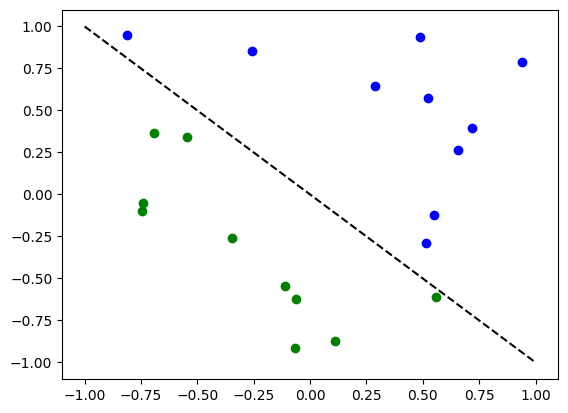

In [3]:
num_inputs = 2
num_samples = 20
X = 2 * algorithm_globals.random.random([num_samples, num_inputs]) - 1
y01 = 1 * (np.sum(X, axis=1) >= 0)  # in { 0,  1}
y = 2 * y01 - 1  # in {-1, +1}
y_one_hot = np.zeros((num_samples, 2))
for i in range(num_samples):
    y_one_hot[i, y01[i]] = 1

for x, y_target in zip(X, y):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

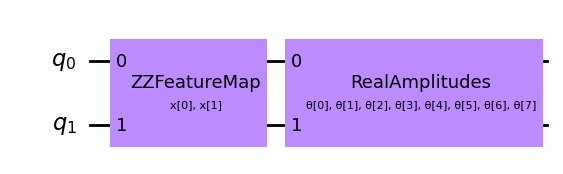

In [4]:
# construct QNN with the QNNCircuit's default ZZFeatureMap feature map and RealAmplitudes ansatz.
qc = QNNCircuit(num_qubits=2)
qc.draw("mpl", style="clifford")

In [5]:
estimator = Estimator()
estimator_qnn = EstimatorQNN(circuit=qc, estimator=estimator)

No gradient function provided, creating a gradient function. If your Estimator requires transpilation, please provide a pass manager.


In [6]:
# QNN maps inputs to [-1, +1]
estimator_qnn.forward(X[0, :], algorithm_globals.random.random(estimator_qnn.num_weights))

array([[0.21616095]])

In [7]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [8]:
# construct neural network classifier
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

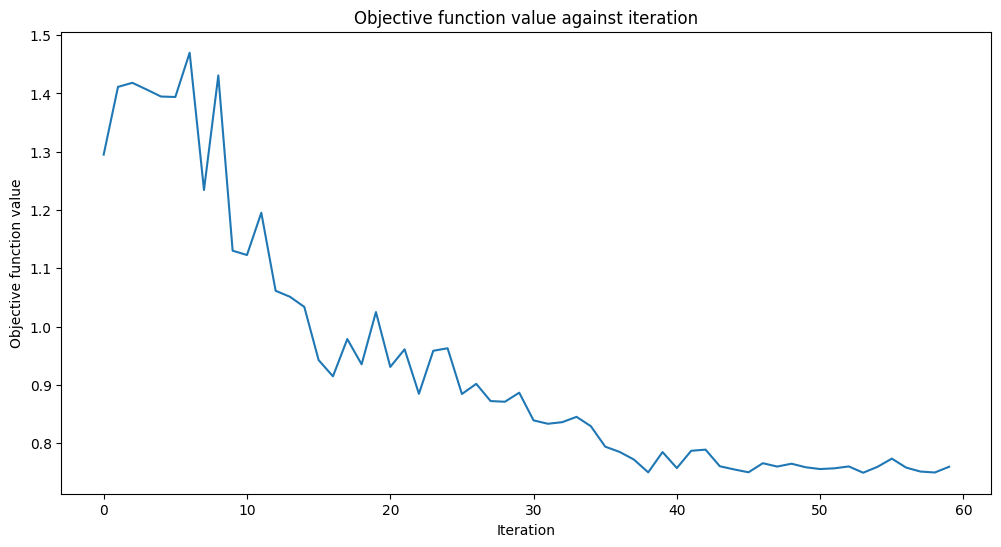

0.75

In [9]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X, y)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X, y)

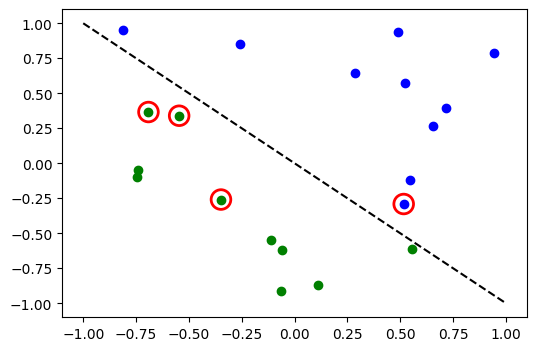

In [10]:
# evaluate data points
y_predict = estimator_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Classification with Sampler

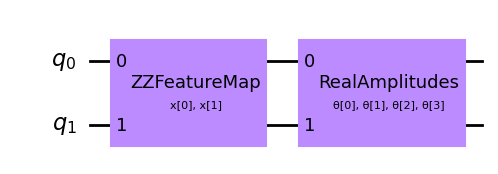

In [11]:
# construct a quantum circuit from the default ZZFeatureMap feature map and a customized RealAmplitudes ansatz
qc = QNNCircuit(ansatz=RealAmplitudes(num_inputs, reps=1))
qc.draw("mpl", style="clifford")

In [12]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [13]:
sampler = Sampler()
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


In [14]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=30), callback=callback_graph
)

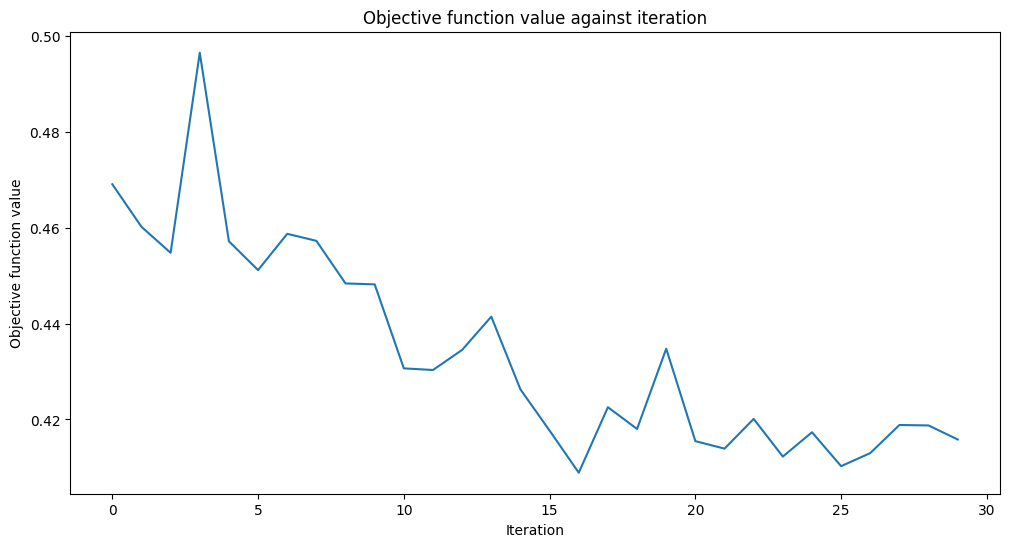

0.65

In [15]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X, y01)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X, y01)

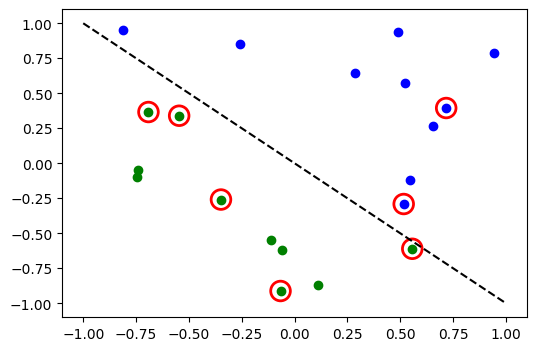

In [16]:
# evaluate data points
y_predict = sampler_classifier.predict(X)

# plot results
# red == wrongly classified
for x, y_target, y_p in zip(X, y01, y_predict):
    if y_target == 1:
        plt.plot(x[0], x[1], "bo")
    else:
        plt.plot(x[0], x[1], "go")
    if y_target != y_p:
        plt.scatter(x[0], x[1], s=200, facecolors="none", edgecolors="r", linewidths=2)
plt.plot([-1, 1], [1, -1], "--", color="black")
plt.show()

### Multiple Classes Classification with VQC

In [17]:
X, y = make_classification(
    n_samples=10,
    n_features=2,
    n_classes=3,
    n_redundant=0,
    n_clusters_per_class=1,
    class_sep=2.0,
    random_state=algorithm_globals.random_seed,
)
X = MinMaxScaler().fit_transform(X)

In [19]:
y_cat = np.empty(y.shape, dtype=str)
y_cat[y == 0] = "A"
y_cat[y == 1] = "B"
y_cat[y == 2] = "C"
print(y_cat)

['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


In [20]:
vqc = VQC(
    num_qubits=2,
    optimizer=COBYLA(maxiter=30),
    callback=callback_graph,
    sampler=sampler,
)

No gradient function provided, creating a gradient function. If your Sampler requires transpilation, please provide a pass manager.


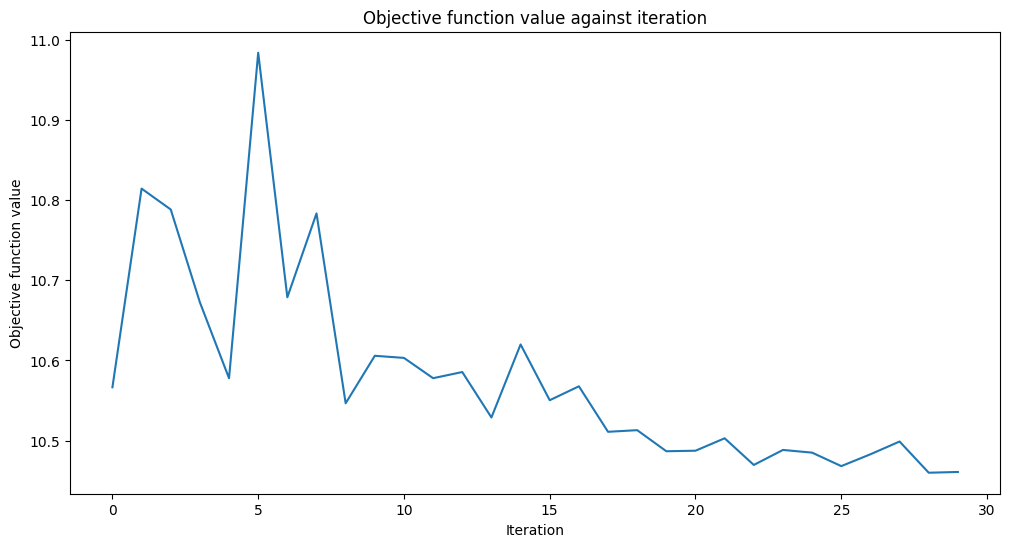

0.5

In [21]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X, y_cat)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X, y_cat)

In [22]:
predict = vqc.predict(X)
print(f"Predicted labels: {predict}")
print(f"Ground truth:     {y_cat}")

Predicted labels: ['A' 'A' 'B' 'A' 'B' 'B' 'B' 'B' 'B' 'B']
Ground truth:     ['A' 'A' 'B' 'C' 'C' 'A' 'B' 'B' 'A' 'C']


### Train Quantum Machine Learning Using Real Dataset

In [28]:
iris_data = load_iris()
X = iris_data.data
y = iris_data.target

X = MinMaxScaler().fit_transform(X)

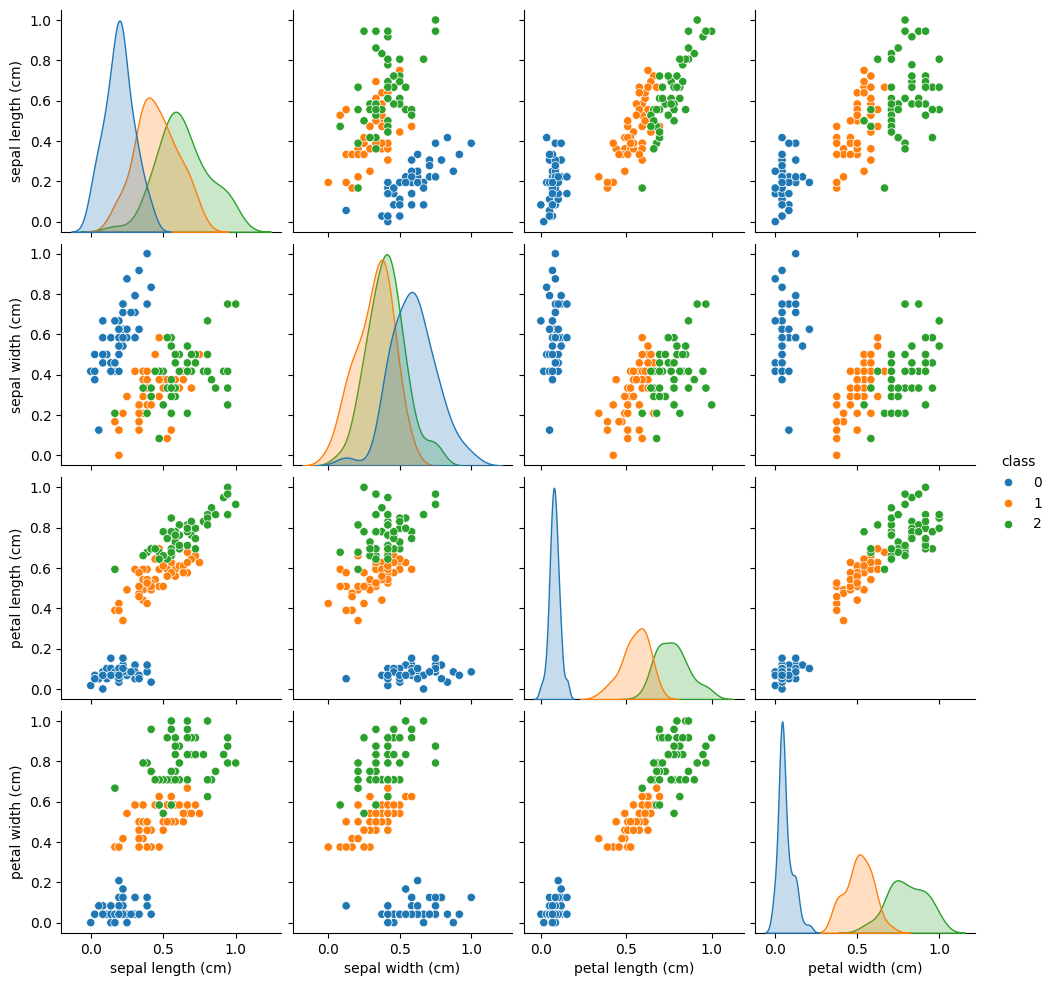

In [33]:
iris_df = pd.DataFrame(X, columns=iris_data.feature_names)
iris_df['class'] = y


sns.pairplot(iris_df, hue="class", palette="tab10")

In [52]:
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [57]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   class              150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


<Axes: xlabel='class'>

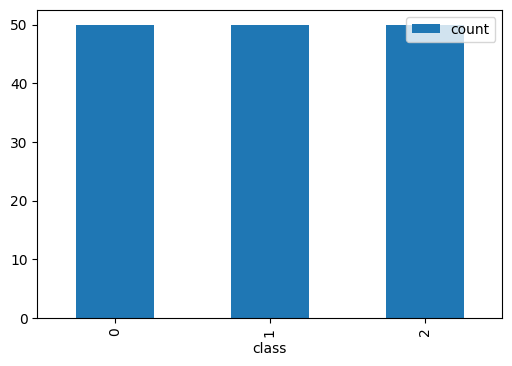

In [68]:
iris_df['class'].value_counts().plot.bar(legend=True)

In [37]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=algorithm_globals.random_seed)

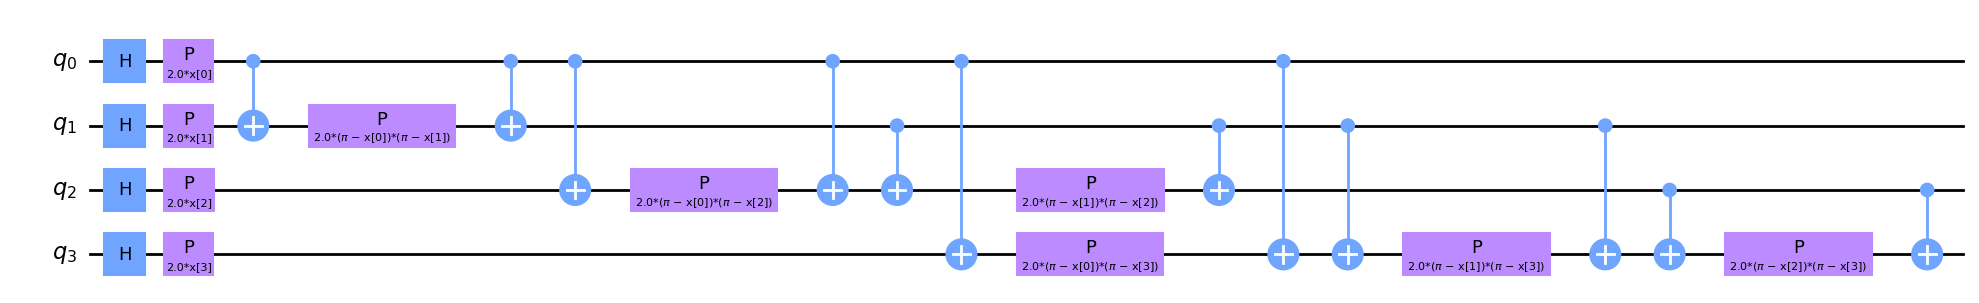

In [38]:
num_features = X.shape[1]

feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
feature_map.decompose().draw(output='mpl', style='clifford', fold=-1)

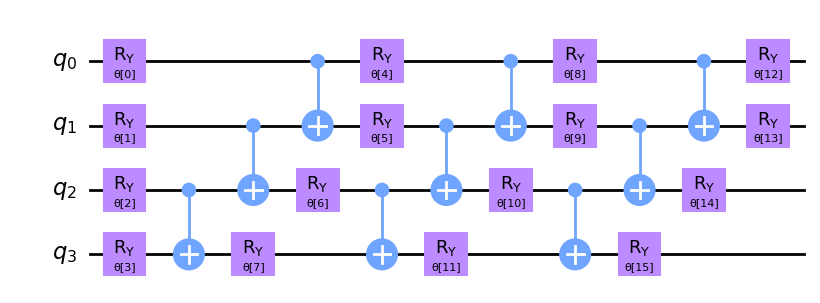

In [40]:
ansatz = RealAmplitudes(num_qubits=num_features, reps=3)
ansatz.decompose().draw(output='mpl', style='clifford', fold=-1)

In [45]:
optimizer = COBYLA(maxiter=100)
sampler = Sampler()

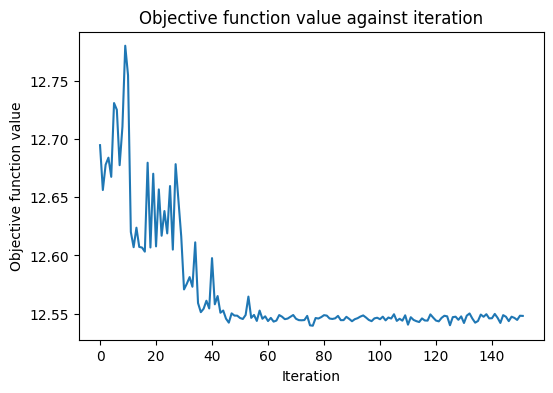

Training time: 164 seconds


In [46]:
vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)

# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(X_train, y_train)
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [47]:
pred_score = vqc.score(X_test, y_test)
print(f'Quantum VQC model test score: {pred_score:.2f}')

Quantum VQC model test score: 0.71
